# Neural & Behavioral Modeling - Week 13 (Exercises)
by 劉昱維 (r08227111@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
%env KMP_DUPLICATE_LIB_OK=TRUE
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim
import random

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.7.0+cu101
Device  0 : GeForce GTX 1050 Ti
Current: Device  0


In [3]:
# Prepare train/test data/ train method
from torchvision import datasets, transforms
import random
from datetime import datetime

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])

train_set = datasets.MNIST(root = "./data",
                               transform = transform,
                               train = True,
                               download = True)

train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.MNIST(root = "./data",
                              transform = transform,
                              train = False)

test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

## 1. RNN on images (5 points)
Note that the RNN-based MNIST classifier in 2.1.1 of 13_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

In [4]:
# Thoe model in 2.1.1 of 13_examples.ipynb:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

class RNN_AddSoftMax(nn.Module):
    def __init__(self):
        super(RNN_AddSoftMax, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        self.classifier = nn.Linear(128,10)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.softmax(output)
        output = self.classifier(output[:,-1,:])
        return output   

In [11]:
# Please run your computational experiments and write your observations accordingly.

# Anyway, fix seed first! 
seed=5
t.manual_seed(seed)
t.cuda.manual_seed(seed)
t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True


print("#"*20 + " Origin RNN " + "#"*20)
srn = RNN()
optimizer = optim.Adam(srn.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srn, train_data, test_data, 3, optimizer, criterion)

print("#"*20 + " Adding Softmax RNN " + "#"*20)
srna = RNN_AddSoftMax()
optimizer = optim.Adam(srna.parameters())
criterion = nn.CrossEntropyLoss()
train(device, srna, train_data, test_data, 3, optimizer, criterion)

#################### Origin RNN ####################
Epoch 0. Train Loss: 0.693141, Train Acc: 0.776003, Valid Loss: 0.336545, Valid Acc: 0.900876, Time 00:00:12
Epoch 1. Train Loss: 0.295849, Train Acc: 0.915462, Valid Loss: 0.273534, Valid Acc: 0.920581, Time 00:00:14
Epoch 2. Train Loss: 0.226583, Train Acc: 0.935118, Valid Loss: 0.226356, Valid Acc: 0.934614, Time 00:00:15
#################### Adding Softmax RNN ####################
Epoch 0. Train Loss: 1.457754, Train Acc: 0.561051, Valid Loss: 0.943463, Valid Acc: 0.713575, Time 00:00:13
Epoch 1. Train Loss: 0.771504, Train Acc: 0.771755, Valid Loss: 0.576080, Valid Acc: 0.831310, Time 00:00:15
Epoch 2. Train Loss: 0.625306, Train Acc: 0.822445, Valid Loss: 0.460811, Valid Acc: 0.876493, Time 00:00:15


### 觀察到"增加Softmax後"，學習準確率變差了 
![Observed1](https://i.imgur.com/vFfKRyu.jpeg)

In [17]:
def softmax(x):
    """Compute the softmax of vector x."""
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x
_s = softmax([5,2,1])
_ss = softmax(_s)
_sss = softmax(_ss)
print(_s)
print(_ss)
print(_sss)

[0.93623955 0.04661262 0.01714783]
[0.55258078 0.22700515 0.22041407]
[0.40992355 0.29601053 0.29406592]


## 查看[Document](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):
### 發現pytorch中nn.CrossEntropyLoss()是將 nn.LogSoftmax() 和nn.NLLLoss()兩個方法結合起來。
所以我們多加一層Softmax的話，就會使得結果更差~
![observed2](https://i.imgur.com/NCZuIsH.jpg)

## 2. RNN v.s. CNN (5 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in 13_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

In [5]:
# Prepare windowed data for our RNN model(s):
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')


# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, ts))

def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)

# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

Epoch: 100, Loss: 0.00354
Epoch: 200, Loss: 0.00157
Epoch: 300, Loss: 0.00076
Epoch: 400, Loss: 0.00050
Epoch: 500, Loss: 0.00044
Epoch: 600, Loss: 0.00027
Epoch: 700, Loss: 0.00018
Epoch: 800, Loss: 0.00013
Epoch: 900, Loss: 0.00012
Epoch: 1000, Loss: 0.00010
torch.Size([142, 1, 1]) (142,) 144


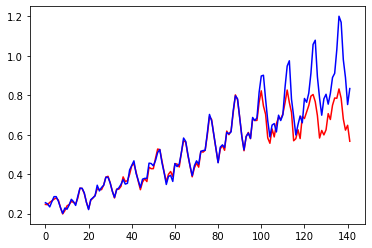

In [6]:
# 2.2.1 (RNN):
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # flatten
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    
net = lstm_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
        
# Testing on the whole series (70% trained + 30% untrained):
_net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = _net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

torch.Size([99, 1, 2]) torch.Size([99, 1])
Epoch: 100, Loss: 679.75250
Epoch: 200, Loss: 570.19324
Epoch: 300, Loss: 532.33081
Epoch: 400, Loss: 525.92883
Epoch: 500, Loss: 524.48120
Epoch: 600, Loss: 523.31030
Epoch: 700, Loss: 522.12531
Epoch: 800, Loss: 520.93542
Epoch: 900, Loss: 519.75702
Epoch: 1000, Loss: 518.60388
torch.Size([142, 1]) (142,) 144


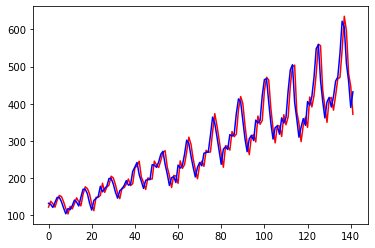

In [11]:
# Train-Test split:
data_X4 = np.swapaxes(data_X,1,2) # should be (batch, channel, input)
L=data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)
# 2.3.1 (CNN):
class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size):
        super(cnn_reg, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features

        self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x=x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x
    
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)

# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # print loss every 100 epochs
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
        
# Testing on the whole series (70% trained + 30% untrained):
net = net.eval() 
pred_test1 = net(t.from_numpy(data_X4))
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

## 1.可以發現原始資料本身的Pattern是很有規律的，照理來說RNN應可以抓這個週期。

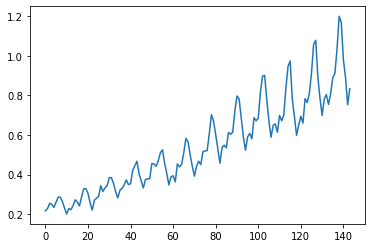

In [7]:
plot(dataset)

## 2.可是我們卻發現學到後面漸漸開始失真

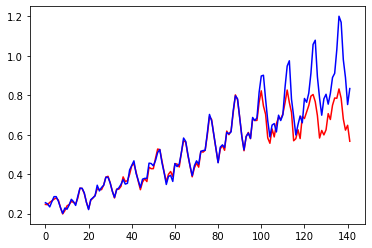

In [8]:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

## 3.時間序列性的模型會隨著要預測越久以後的現象，準確率越低；但若是模型能夠一次看"多一些"資料，便能看見長流中的趨勢，雖然相對短時間內的預測就會變得比較不準(如果短時間內變動大的話)，是為見林；一次看"少一點"資料的話則可以抓到短時間內的週期，但就不太能看到常週期的變化(如果長周期持續變化的話)，是為見樹。

上面的預測結果應該是見樹不見林，下面用不同的inputsize[2,4,12]來觀察RNN的預測結果看是否能見林。

In [9]:
# Anyway, fix seed first! 
seed=5
t.manual_seed(seed)
t.cuda.manual_seed(seed)
t.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
t.backends.cudnn.benchmark = True
t.backends.cudnn.deterministic = True



## Inputsize=2

torch.Size([142, 1, 1]) (142,) 144


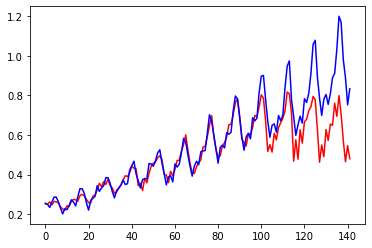

In [10]:
net = lstm_reg(input_size=2, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if (e + 1) % 100 == 0: # print loss every 100 epochs
#         print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
        
# Testing on the whole series (70% trained + 30% untrained):
_net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 2)
data_X3 = t.from_numpy(data_X2)
pred_test1 = _net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[2:], 'b', label='real');

## Inputsize=4

torch.Size([140, 1, 1]) (140,) 144


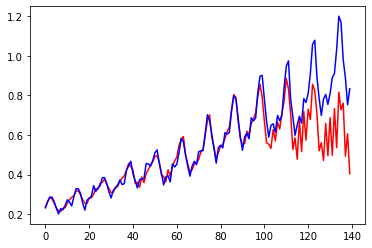

In [16]:
data_X, data_Y = create_dataset(dataset,4)

# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 4)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

net = lstm_reg(input_size=4, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
# Training:
for e in range(1000+50*4):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if (e + 1) % 100 == 0: # print loss every 100 epochs
#         print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
        
# Testing on the whole series (70% trained + 30% untrained):
_net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 4)
data_X3 = t.from_numpy(data_X2)
pred_test1 = _net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[4:], 'b', label='real');

## Inputsize=12

torch.Size([132, 1, 1]) (132,) 144


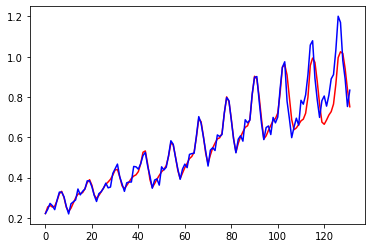

In [18]:
data_X, data_Y = create_dataset(dataset,12)

# Train-Test split:
train_size = int(len(data_X) * 0.7) # 70% for training
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

# Reshape the data into (seq, batch, featue)
train_X = train_X.reshape(-1, 1, 12)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

net = lstm_reg(input_size=12, hidden_size=10)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(),lr=1e-2)
# Training:
for e in range(1000):
    # Forward:
    out = net(train_x)
    loss = criterion(out, train_y)
    # Backward:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
#     if (e + 1) % 100 == 0: # print loss every 100 epochs
#         print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))
        
# Testing on the whole series (70% trained + 30% untrained):
_net = net.eval() 
data_X2 = data_X.reshape(-1, 1, 12)
data_X3 = t.from_numpy(data_X2)
pred_test1 = _net(data_X3) 
pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
print(pred_test1.shape, pred_test2.shape, len(dataset))

# Visualization:
plot(pred_test2, 'r', label='prediction')
plot(dataset[12:], 'b', label='real');

## 結論: 調整Inputsize後RNN學起來了這個Pattern
那麼如果來一個陌生的資料集，該怎麼選擇Inputsize呢?  -> Domain Knowledge的珍貴之處